In [1]:
import pandas
import numpy as np
import re
import os
import string
from ipyparallel import Client

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer,porter
from nltk.corpus import stopwords

from gensim.models.doc2vec import LabeledSentence,TaggedDocument
from gensim.models import Doc2Vec

from random import shuffle

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import metrics

from IPython.display import display

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## define pre processing functions

In [2]:
def noPunct(txt):
    punct_list = string.punctuation + '’' + '”'
    for punct in punct_list:
        txt = txt.replace(punct,'')
    return txt

def noNumber(txt):
    return re.sub(r'[$\s]*\d+\.?\d*','',txt)

extra_stopwords = stopwords.words('english') + ['nt','wo','wa','tg','va','ca','mo','le','ha','sm','itt','k']

def LemmaTokenizer(doc):
    wnl = WordNetLemmatizer()
    lemmas = [wnl.lemmatize(str.lower(spell(t))) for t in word_tokenize(doc)]
    lemmas = [noPunct(l) for l in lemmas]
    lemmas = [noNumber(l) for l in lemmas]
    lemmas = [x for x in lemmas if x not in extra_stopwords]
    lemmas = list(filter(lambda x: len(x) > 0,lemmas))
    return lemmas

## Read Review Data

In [3]:
def maxCase(x):
    result = [i for (i,v) in zip(range(-2,3),[y==max(x) for y in x]) if v]
    if(len(result) > 1):
        s = sum(result)
        if(s < -2):
            return -2
        elif(s > 2):
            return 2
        else:
            return s
    else:
        return result[0]
    
def worstCase(x):
    if x['vneg']>0:
        return -2
    elif x['neg']>0:
        return -1
    elif x['neutral']>0:
        return 0
    elif x['pos']>0:
        return 1
    else:
        return 2
    
def bestCase(x):
    if x['vpos']>0:
        return 2
    elif x['pos']>0:
        return 1
    elif x['neutral']>0:
        return 0
    elif x['neg']>0:
        return -1
    else:
        return -2
    
def twoClass(x):
    if x<0:
        return -1
    else:
        return 1

reviews = pandas.read_pickle('consumer_affairs_sallie_mae.data')
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'referenceevery','reference every',x,flags=re.IGNORECASE))
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'acct','account',x,flags=re.IGNORECASE))
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'thats','that\'s',x,flags=re.IGNORECASE))
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'interesrt','interest',x,flags=re.IGNORECASE))
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'don\'t','do not',x,flags=re.IGNORECASE))
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'wouldn\'t','would not',x,flags=re.IGNORECASE))
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'couldn\'t','could not',x,flags=re.IGNORECASE))
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'shouldn\'t','should not',x,flags=re.IGNORECASE))

sentiments = pandas.read_csv('review_sentiment_coreNLP.txt')
sentiments_R = pandas.read_csv('Score_of_reviews.csv')['scores']
reviews['sentiment'] = sentiments.apply(bestCase,axis=1).apply(twoClass)

## For each document/review, create a list of tokens and give it a label

In [5]:
exec(open('parallel_doc_operation.py',encoding='utf-8').read())

client = Client()
v = client.direct_view()

pile = v.map(operation,reviews['review'],reviews.index)
docs = pile.result()

## Train the Doc2Vec model

In [6]:
d2v = Doc2Vec(documents=docs,min_count=1,dm=1,dbow_words=0,dm_concat=0,hs=1,negative=0,iter=5,
              alpha=0.05,min_alpha=0.05,window=10,size=1000,sample=1e-4,workers=8)

In [7]:
d2v.alpha -= 0.0001
d2v.min_alpha = d2v.alpha
while(d2v.alpha > 0):
    print('Alpha: ' + str(d2v.alpha))
    shuffle(docs)
    d2v.train(docs)
    d2v.alpha -= 0.0001
    d2v.min_alpha = d2v.alpha

'''
iters = 1000 - d2v.train_count
for i in range(iters):
    print('Iteration: ' + str(i+1) + ' of ' + str(iters))
    shuffle(docs)
    d2v.train(docs)
'''

d2v.init_sims()

Alpha: 0.0499
Alpha: 0.0498
Alpha: 0.049699999999999994
Alpha: 0.04959999999999999
Alpha: 0.04949999999999999
Alpha: 0.049399999999999986
Alpha: 0.04929999999999998
Alpha: 0.04919999999999998
Alpha: 0.04909999999999998
Alpha: 0.048999999999999974
Alpha: 0.04889999999999997
Alpha: 0.04879999999999997
Alpha: 0.048699999999999966
Alpha: 0.04859999999999996
Alpha: 0.04849999999999996
Alpha: 0.04839999999999996
Alpha: 0.048299999999999954
Alpha: 0.04819999999999995
Alpha: 0.04809999999999995
Alpha: 0.047999999999999945
Alpha: 0.04789999999999994
Alpha: 0.04779999999999994
Alpha: 0.04769999999999994
Alpha: 0.047599999999999934
Alpha: 0.04749999999999993
Alpha: 0.04739999999999993
Alpha: 0.047299999999999925
Alpha: 0.04719999999999992
Alpha: 0.04709999999999992
Alpha: 0.04699999999999992
Alpha: 0.046899999999999914
Alpha: 0.04679999999999991
Alpha: 0.04669999999999991
Alpha: 0.046599999999999905
Alpha: 0.0464999999999999
Alpha: 0.0463999999999999
Alpha: 0.0462999999999999
Alpha: 0.04619999999

## Examples of word embedding

In [13]:
display(d2v.similar_by_vector(d2v['problem'] + d2v['payment'],5))
display(d2v.similar_by_vector(d2v['frequent'] + d2v['problem'],5))
display(d2v.similar_by_vector(d2v['automatic'] + d2v['bill'],5))
display(d2v.similar_by_vector(d2v['complain'] - d2v['never'],5))

[('problem', 0.8623752593994141),
 ('payment', 0.5594316720962524),
 ('website', 0.3782522678375244),
 ('fault', 0.34057143330574036),
 ('insurance', 0.338922381401062)]

[('frequent', 0.9934288263320923),
 ('rehab', 0.5079625844955444),
 ('disadvantage', 0.47209978103637695),
 ('infection', 0.462231308221817),
 ('cheating', 0.44229912757873535)]

[('automatic', 0.9165824055671692),
 ('bill', 0.5151885747909546),
 ('unsub', 0.42471522092819214),
 ('hauling', 0.4135284125804901),
 ('reeducating', 0.4086691737174988)]

[('complain', 0.9863442182540894),
 ('expeditiously', 0.42924633622169495),
 ('repaymentrecently', 0.41004109382629395),
 ('bully', 0.3757942318916321),
 ('owns', 0.37018972635269165)]

## Word Vector Space

In [25]:
pandas.DataFrame(d2v.syn0,index=[list(d2v.vocab.keys())[d2v.vocab[x].index] for x in d2v.vocab]).head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
mailing,-0.203262,0.117101,0.021691,0.391467,-0.150065,0.065652,-0.168651,0.075360,0.149411,0.012526,...,-0.272005,-0.170031,0.254240,0.092728,-0.112816,0.019051,-0.124971,-0.019215,-0.026894,-0.027966
annoying,-0.148679,-0.080324,-0.157632,0.227030,0.103935,0.384088,0.081957,0.205896,-0.071274,-0.008387,...,0.144559,0.228045,0.183802,-0.211312,0.052052,0.069265,-0.181597,-0.050573,0.123402,0.109101
deferment,-0.049771,0.030623,-0.095553,0.198874,0.083228,-0.043355,-0.127914,0.124137,-0.092115,0.325649,...,-0.124713,-0.243890,-0.086817,0.189943,0.057854,-0.127808,-0.081435,-0.176281,-0.232295,-0.159443
minimum,-0.050695,0.025726,0.093506,0.150413,0.110169,-0.079242,0.025359,0.001480,-0.134239,0.248367,...,0.157929,-0.100994,-0.084908,-0.062799,-0.072507,0.048884,0.007836,-0.167964,0.030823,-0.038484
deserve,-0.221500,0.198463,0.064316,-0.019038,0.126456,0.113077,0.055519,-0.198728,-0.082564,0.096927,...,-0.129330,-0.141575,0.100678,-0.248061,-0.060377,0.157494,0.158652,0.105073,0.069701,-0.003245


## Document Vector Space

In [29]:
pandas.DataFrame(d2v.docvecs.doctag_syn0).head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-3.560364,0.818038,2.170002,0.473237,-3.481120,-0.457518,0.068737,4.243671,-1.315033,0.798798,...,1.028888,-1.994921,0.600228,3.395888,1.431452,1.699303,0.359906,-1.222672,1.096739,1.372275
1,-1.126182,0.473053,-0.309320,-1.588380,1.920549,-0.102205,2.469981,0.508108,1.786149,0.034056,...,-0.890344,-2.474929,2.820262,1.275928,-2.672972,-2.479254,2.092416,3.113511,-1.204314,0.424701
2,-0.377053,1.739753,3.876655,1.903005,-1.184864,-2.250881,-0.502065,2.168754,-3.578228,-1.958441,...,0.420966,-1.816957,0.058916,-1.967812,0.355980,-0.374911,1.351868,0.438988,-0.537265,0.514833
3,0.034418,-0.716982,0.925260,0.377103,2.157094,-0.562235,-1.686535,-2.315544,-0.359166,-1.975879,...,-0.011733,0.745216,1.222080,-0.278948,1.692187,0.585705,-0.309470,0.370414,-1.517486,2.734728
4,0.429769,1.551948,1.449834,-1.130850,2.297340,-0.666073,-1.174909,2.435758,0.369574,-0.916721,...,-0.588188,0.724465,1.813606,0.321966,0.127612,2.018814,1.015912,-2.302411,-2.658008,1.490939


## Create TSNE 2-D projection of the word vectors

In [9]:
tsne = TSNE(n_components=2, perplexity=30.0, early_exaggeration=10, learning_rate=500.0, 
                 n_iter=1000, n_iter_without_progress=30, min_grad_norm=1e-07, 
                 metric='euclidean', init='random', verbose=1, random_state=20170210, method='barnes_hut', angle=0.5)

lowdim = tsne.fit_transform(d2v.syn0norm)
pandas.DataFrame(lowdim,columns=['d' + str(i) for i in range(1,lowdim.shape[1]+1)]).to_csv('tsne words.csv',index=False)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 8185
[t-SNE] Computed conditional probabilities for sample 2000 / 8185
[t-SNE] Computed conditional probabilities for sample 3000 / 8185
[t-SNE] Computed conditional probabilities for sample 4000 / 8185
[t-SNE] Computed conditional probabilities for sample 5000 / 8185
[t-SNE] Computed conditional probabilities for sample 6000 / 8185
[t-SNE] Computed conditional probabilities for sample 7000 / 8185
[t-SNE] Computed conditional probabilities for sample 8000 / 8185
[t-SNE] Computed conditional probabilities for sample 8185 / 8185
[t-SNE] Mean sigma: 0.255668
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.533037
[t-SNE] Error after 300 iterations: 1.533037


In [18]:
pandas.DataFrame(lowdim,columns=['d' + str(i) for i in range(1,lowdim.shape[1]+1)]).head()

,d1,d2
0,0.285204,1.713025
1,1.112161,4.804369
2,-4.592331,1.352028
3,1.232670,4.826522
4,-2.570230,0.405884


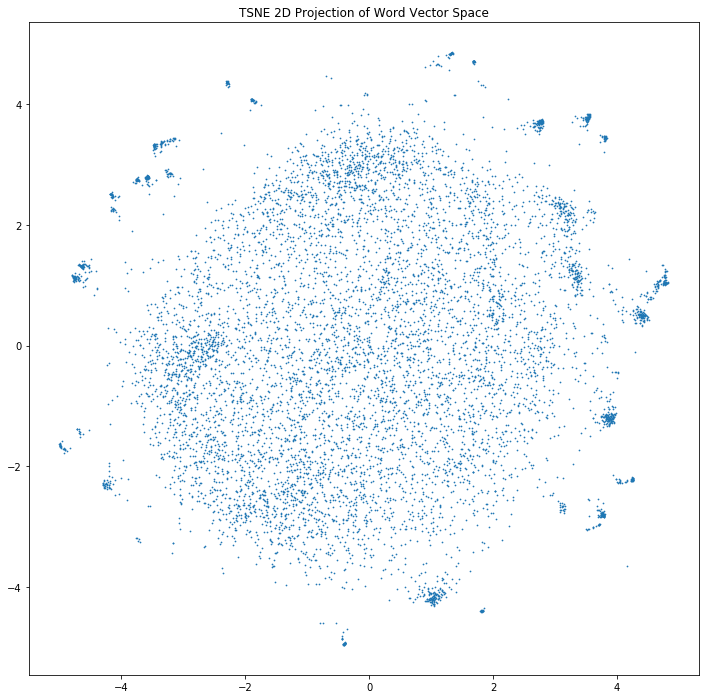

In [10]:
plt.figure(figsize=(12,12))
plt.scatter(lowdim[:,0],lowdim[:,1],s=0.5)
words = list(d2v.vocab.keys())
#for i in range(lowdim.shape[0]):
#    plt.annotate(words[i],(lowdim[i,0],lowdim[i,1]))
plt.title('TSNE 2D Projection of Word Vector Space')
plt.show()

## K-means cluster the TSNE data for a range and choose k with best silhouette metric

In [96]:
k = range(2,201)
sil = []
for cl in k:
    clus = KMeans(n_clusters=cl, init='k-means++', n_init=10, max_iter=1000, tol=0.0001, 
                  precompute_distances=True, verbose=0, random_state=None, 
                  copy_x=True, n_jobs=8, algorithm='auto')
    clus.fit(lowdim)
    labels = pandas.Series(clus.labels_,name='cluster')
    sil.append(metrics.silhouette_score(lowdim, labels, metric='sqeuclidean'))
    print(str(cl) + ' of ' + str(max(k)))

2 of 200
3 of 200
4 of 200
5 of 200
6 of 200
7 of 200
8 of 200
9 of 200
10 of 200
11 of 200
12 of 200
13 of 200
14 of 200
15 of 200
16 of 200
17 of 200
18 of 200
19 of 200
20 of 200
21 of 200
22 of 200
23 of 200
24 of 200
25 of 200
26 of 200
27 of 200
28 of 200
29 of 200
30 of 200
31 of 200
32 of 200
33 of 200
34 of 200
35 of 200
36 of 200
37 of 200
38 of 200
39 of 200
40 of 200
41 of 200
42 of 200
43 of 200
44 of 200
45 of 200
46 of 200
47 of 200
48 of 200
49 of 200
50 of 200
51 of 200
52 of 200
53 of 200
54 of 200
55 of 200
56 of 200
57 of 200
58 of 200
59 of 200
60 of 200
61 of 200
62 of 200
63 of 200
64 of 200
65 of 200
66 of 200
67 of 200
68 of 200
69 of 200
70 of 200
71 of 200
72 of 200
73 of 200
74 of 200
75 of 200
76 of 200
77 of 200
78 of 200
79 of 200
80 of 200
81 of 200
82 of 200
83 of 200
84 of 200
85 of 200
86 of 200
87 of 200
88 of 200
89 of 200
90 of 200
91 of 200
92 of 200
93 of 200
94 of 200
95 of 200
96 of 200
97 of 200
98 of 200
99 of 200
100 of 200
101 of 200
102 of

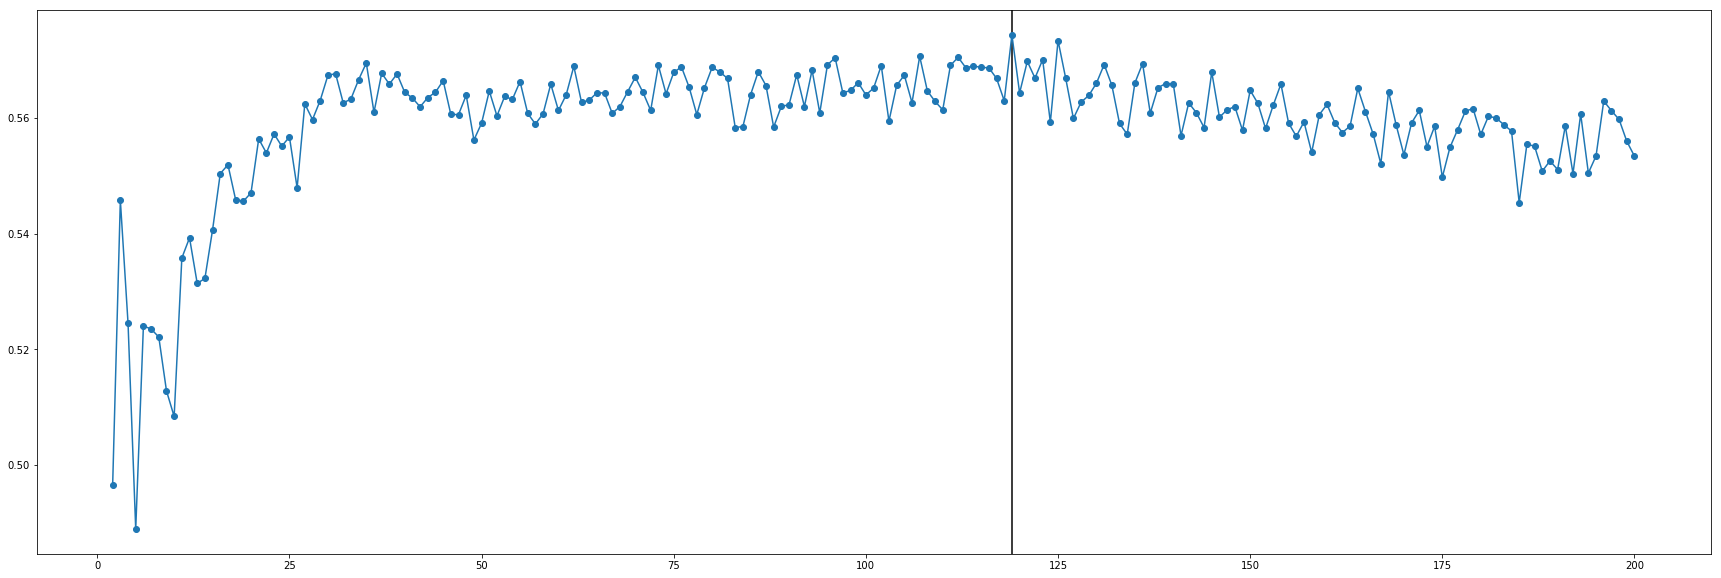

119


In [130]:
plt.figure(figsize=(30,10))
best = k[[i-2 for (i,j) in zip(k,sil) if j==max(sil)][0]]
plt.axvline(x=best,c='black')
plt.plot(k,sil,'-o')
plt.show()
print('Best K: ' + str(best))

In [14]:
clus = KMeans(n_clusters=best, init='k-means++', n_init=10, max_iter=1000, tol=0.0001, 
              precompute_distances=True, verbose=0, random_state=None, 
              copy_x=True, n_jobs=8, algorithm='auto')
clus.fit(lowdim)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=119, n_init=10, n_jobs=8, precompute_distances=True,
    random_state=None, tol=0.0001, verbose=0)

Estimated number of clusters: 119
Silhouette Coefficient: 0.5638


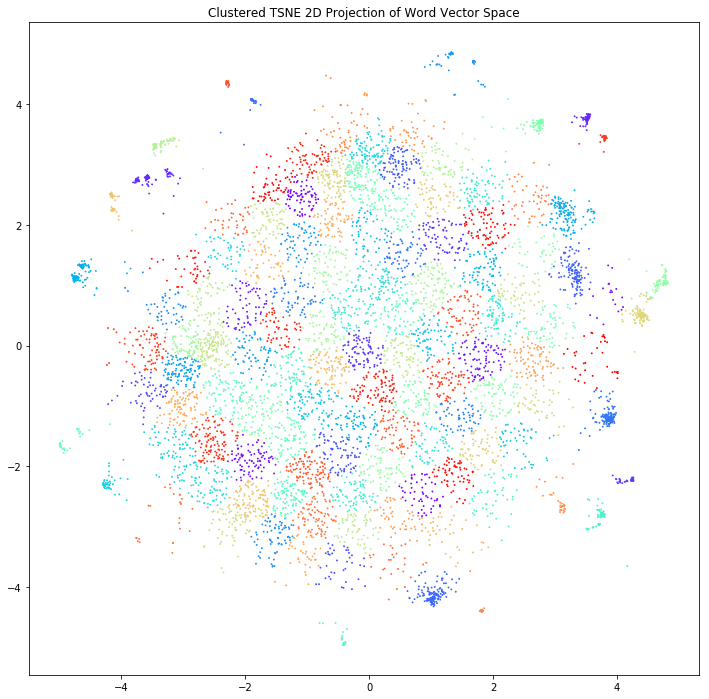

In [16]:
labels = pandas.Series(clus.labels_,name='cluster')
n_clusters = len(labels.value_counts())
print('Estimated number of clusters: {}'.format(n_clusters))
print('Silhouette Coefficient: {:1.4f}'.format(metrics.silhouette_score(lowdim, labels, metric='sqeuclidean')))

colors = cm.rainbow(np.linspace(0, 1, best))
colors = dict(zip(labels.sort_values().drop_duplicates(),colors))

plt.figure(figsize=(12,12))
plt.scatter(lowdim[:,0], lowdim[:,1], color=[colors[x] for x in labels.values],s=0.75)
plt.title('Clustered TSNE 2D Projection of Word Vector Space')
plt.show()

In [17]:
words_ind = [d2v.vocab[x].index for x in d2v.vocab]

word_clus = pandas.DataFrame({'word':[list(d2v.vocab.keys())[x] for x in words_ind],'clus':labels},columns=['word','clus'])
word_clus = word_clus.groupby('clus').agg({'word':{'word_count':len,'words':lambda x: ','.join(x.values)}})
word_clus.to_excel('word_clus.xlsx')